# Segmentation Cars

In [1]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt
from ipywidgets import FloatProgress
import os
import pathlib
import shutil
from PIL import Image
import numpy as np
import pandas as pd

## Dataset ophalen

In [2]:
directoryInput = 'Images/MRIscansJPG/Input/'
directoryMask = 'Images/MRIscansJPG/Mask/'

In [3]:
content_dir = os.listdir(directoryInput)
print(len(content_dir))
content_dir[:5]

110


['TCGA_CS_4941_19960909',
 'TCGA_CS_4942_19970222',
 'TCGA_CS_4943_20000902',
 'TCGA_CS_4944_20010208',
 'TCGA_CS_5393_19990606']

In [4]:
BATCH_SIZE = 32

### Training set

In [5]:
datasetInput = tf.keras.utils.image_dataset_from_directory(
    directoryInput,
    labels=None,
    image_size=(256,256),
    batch_size=BATCH_SIZE,
    validation_split=0.5,
    subset='training',
    shuffle=False
)

Found 3929 files belonging to 1 classes.
Using 1965 files for training.


In [6]:
datasetMask = tf.keras.utils.image_dataset_from_directory(
    directoryMask,
    labels=None,
    image_size=(256,256),
    batch_size=BATCH_SIZE,
    validation_split=0.5,
    subset='training',
    shuffle=False
)

Found 3929 files belonging to 1 classes.
Using 1965 files for training.


In [7]:
datasetMask.element_spec

TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)

In [8]:
# datasetMask.map(lambda image: image[0])
# testmask = datasetMask.map(tf.image.rgb_to_grayscale)
# testmask = testmask.map(lambda img_mask: tf.where(img_mask > 60, 1, 0))
# testmask = testmask.map(lambda img_mask: tf.one_hot(img_mask, 2))
# testmask = testmask.map(tf.squeeze)
# testmask

In [9]:
dataset = tf.data.Dataset.zip((datasetInput, datasetMask))
dataset

<ZipDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>

In [10]:
print(datasetInput.element_spec)
print(datasetMask.element_spec)
print(dataset.element_spec)

TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)
TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))


In [11]:
batch = next(iter(dataset))
input_batch, mask_batch = batch
print(input_batch.shape)
print(mask_batch.shape)

(32, 256, 256, 3)
(32, 256, 256, 3)


In [12]:
# print("Mask propoerties:")
# for image, mask in dataset:
#     print(f"Min: {np.min(mask)};\nMax: {np.max(mask)};\nShape: {mask.shape};\nAll occuring values: {np.unique(mask[3])}")
#     display([image[3], tf.where(mask[3] > 50, 255, 0)])
#     print(mask[3])
#     break

### Validation set

In [13]:
datasetInput_test = tf.keras.utils.image_dataset_from_directory(
    directoryInput,
    labels=None,
    image_size=(256,256),
    batch_size=BATCH_SIZE,
    validation_split=0.5,
    subset='validation',
    shuffle=False
)

Found 3929 files belonging to 1 classes.
Using 1964 files for validation.


In [14]:
datasetMask_test = tf.keras.utils.image_dataset_from_directory(
    directoryMask,
    labels=None,
    image_size=(256,256),
    batch_size=BATCH_SIZE,
    validation_split=0.5,
    subset='validation',
    shuffle=False
)

Found 3929 files belonging to 1 classes.
Using 1964 files for validation.


In [15]:
# testmaskval = datasetMask_test.map(tf.image.rgb_to_grayscale)
# testmaskval = testmaskval.map(lambda img_mask: tf.where(img_mask > 60, 1, 0))
# testmaskval = testmaskval.map(lambda img_mask: tf.one_hot(img_mask, 2))
# testmaskval = testmaskval.map(tf.squeeze)
# testmaskval

In [16]:
test_batches = tf.data.Dataset.zip((datasetInput_test, datasetMask_test))
test_batches

<ZipDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>

### Afbeeldingen in juiste vorm krijgen

In [17]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    
    # input_mask = afbeelding met elke pixel ingekleurd.
    input_mask = tf.where(input_mask > 60, 1, 0)
    
    return input_image, input_mask

In [18]:
def load_image(input_datapoint, mask_datapoint):
    input_image = tf.image.resize(input_datapoint, (128, 128))
    input_mask = tf.image.resize(mask_datapoint, (128, 128))
    input_mask = tf.image.rgb_to_grayscale(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [19]:
# num_parallel_calls => om meerdere threads te gebruiken
train_images = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_batches = test_batches.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [20]:
print(train_images.element_spec)
print(test_batches.element_spec)

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))


In [21]:
# data = np.arange(16)
# data = data.reshape(2,2,2,2)
# data = np.sum(data, axis=-1).reshape(2,2,2,1)
# data = data.__gt__(8) * 1
# data

In [22]:
# print("Mask propoerties:")
# for img, mask in train_images:
#     print(f"Min: {np.min(mask)};\nMax: {np.max(mask)};\nShape: {mask.shape};\nAmount of unique values: {len(np.unique(mask[3]))};")
#     display([img[3], mask[3]])
#     break

## Data opdelen in batches +  vervormen

In [23]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [24]:
print(train_images.element_spec)
next(iter(train_images))[0].shape

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))


TensorShape([32, 128, 128, 3])

In [25]:
TRAIN_LENGTH = datasetInput.__len__().numpy() * 32
BATCH_SIZE = 32 # => Zie Dataset Ophalen
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [26]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .repeat() # Deze dataset wordt herhaald (oneindig).
    .map(Augment()) # De images worden willekeurig (seed = 42) vervormt (RandomFlip)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [27]:
train_batches

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.int32)>

## Toon image en label

In [28]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

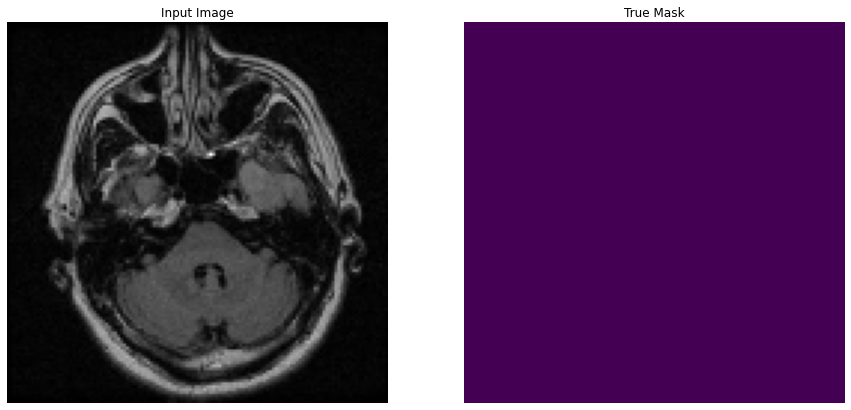

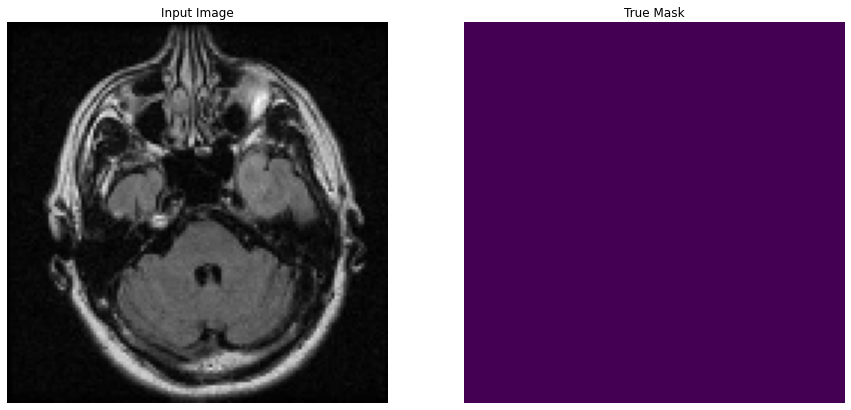

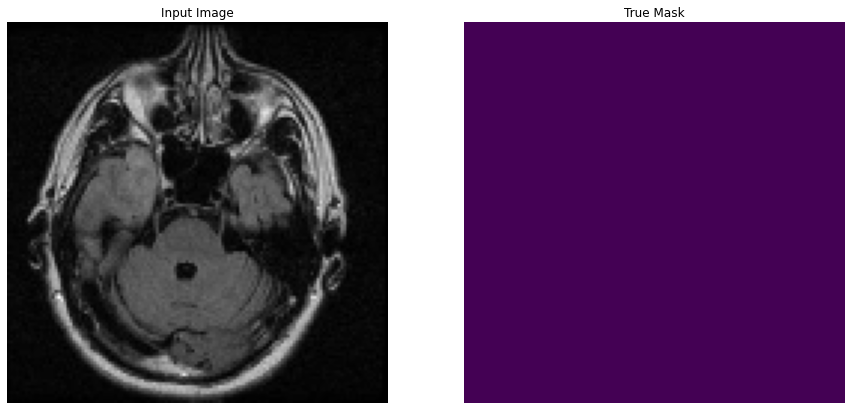

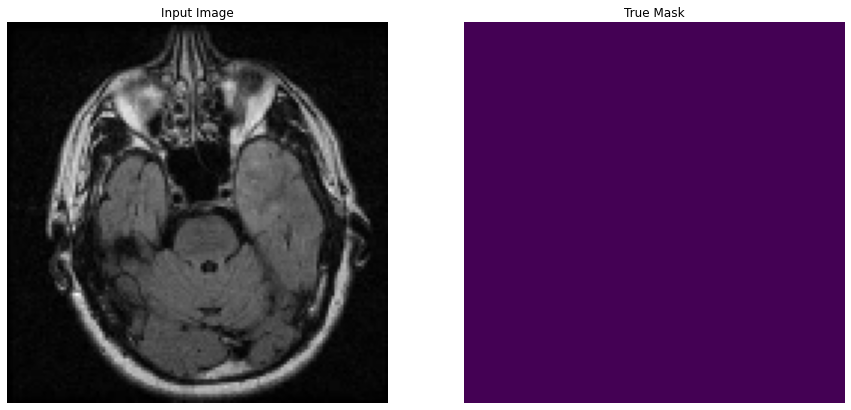

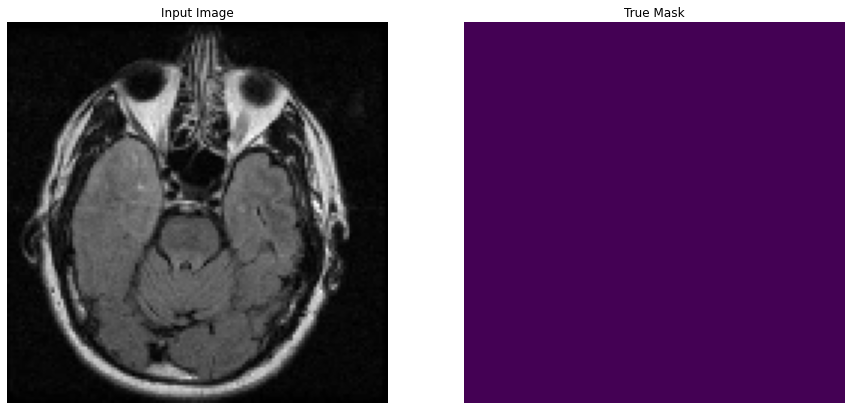

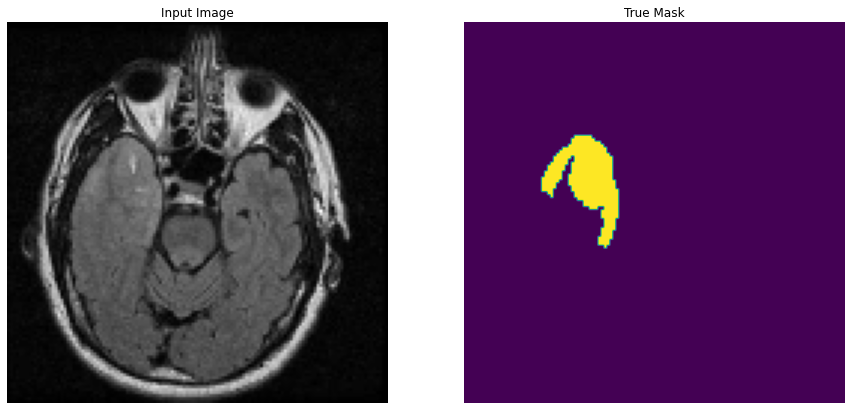

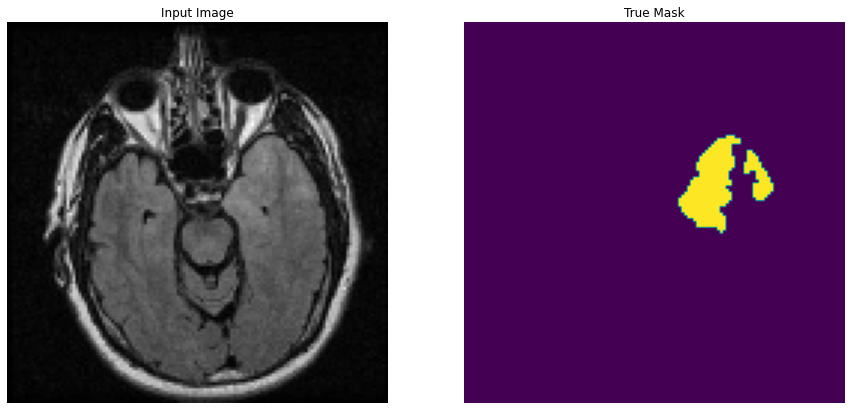

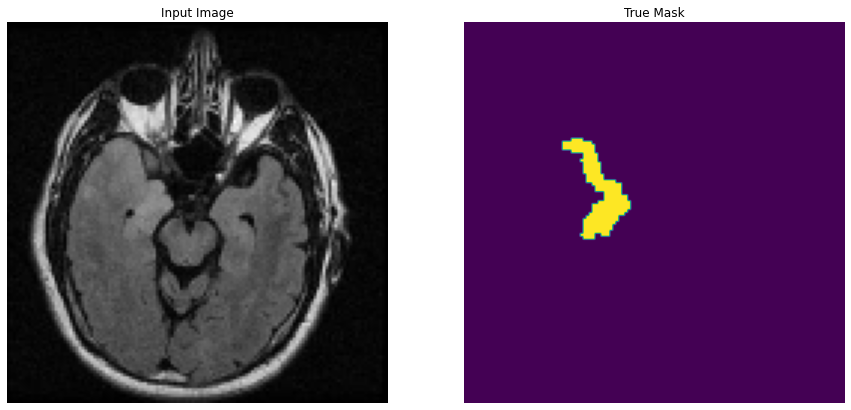

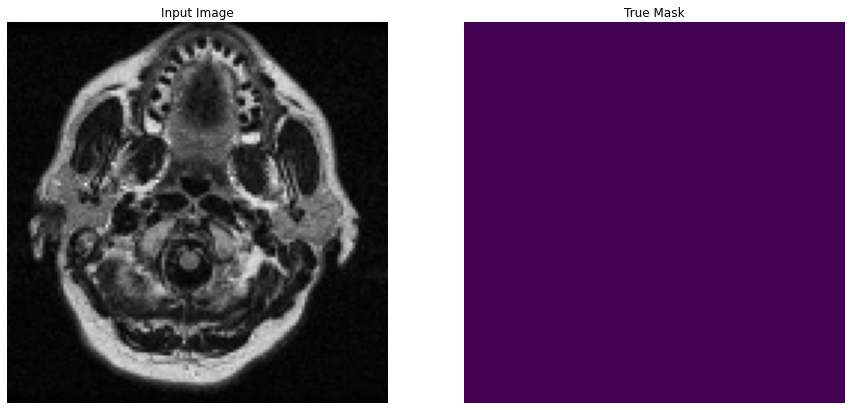

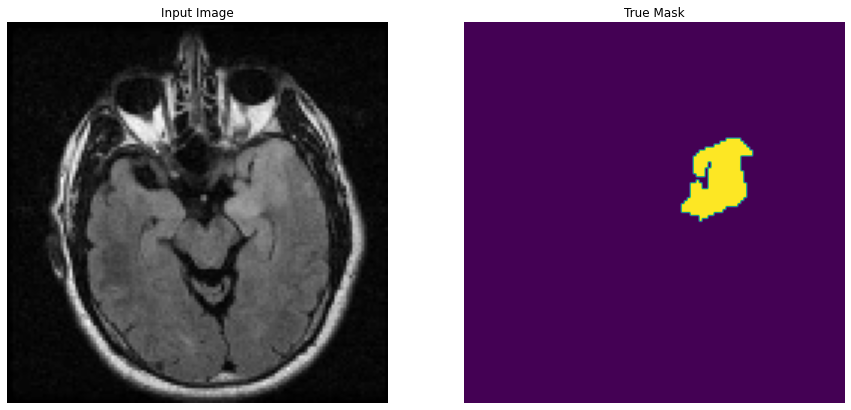

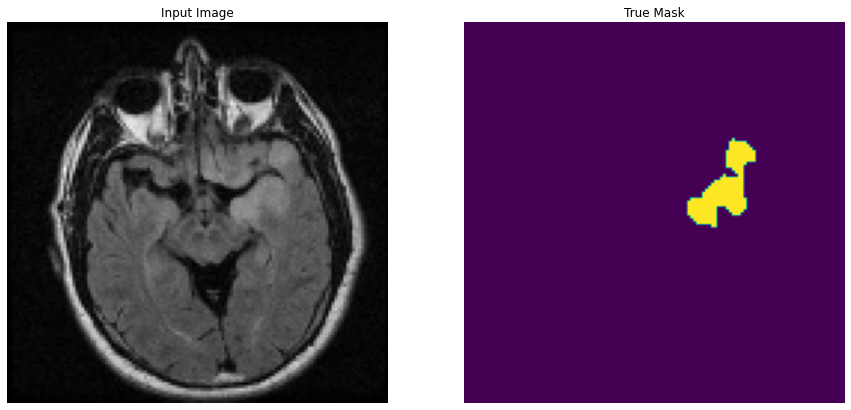

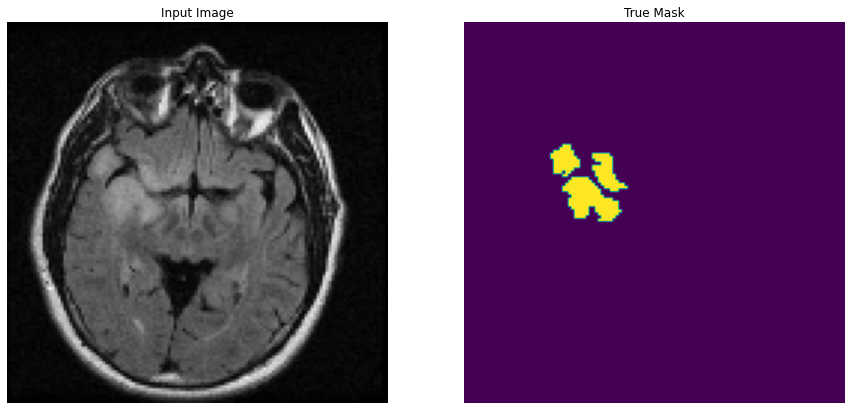

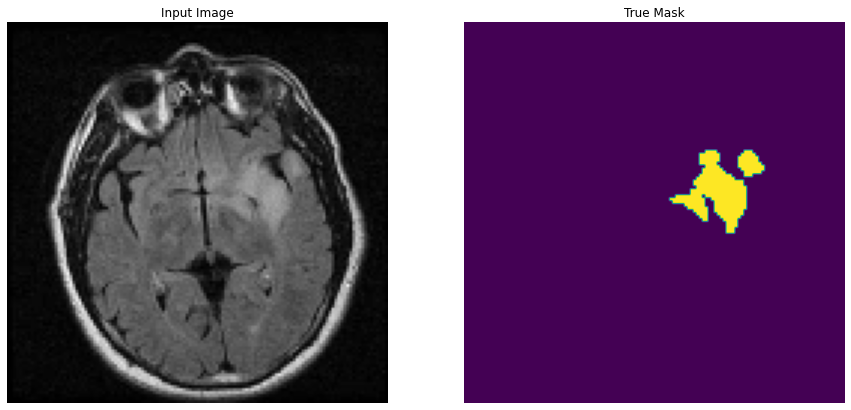

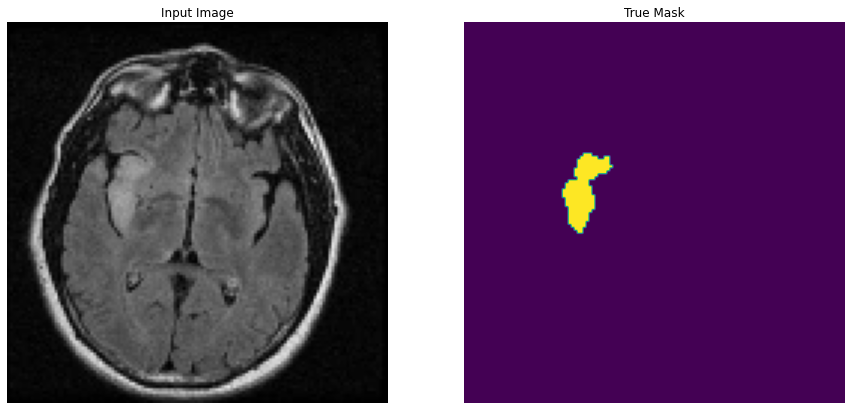

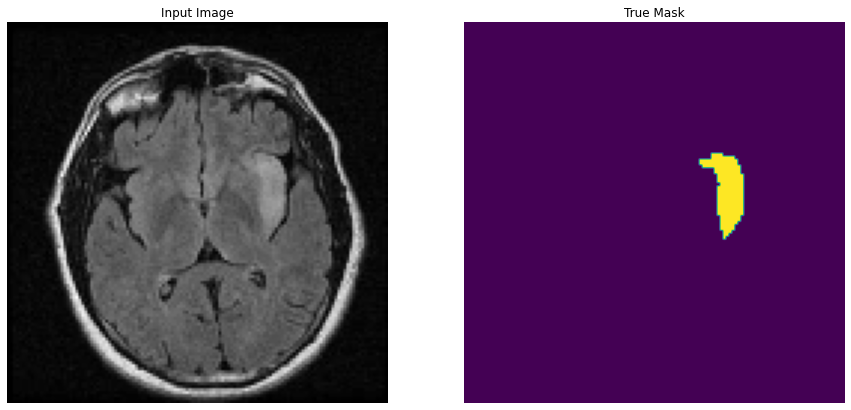

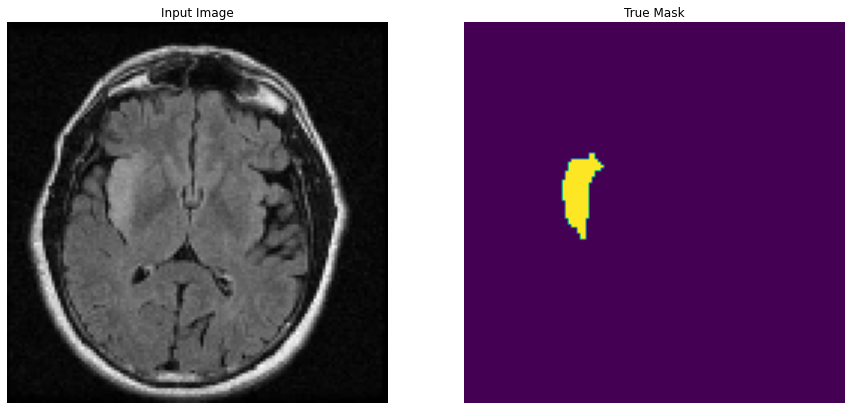

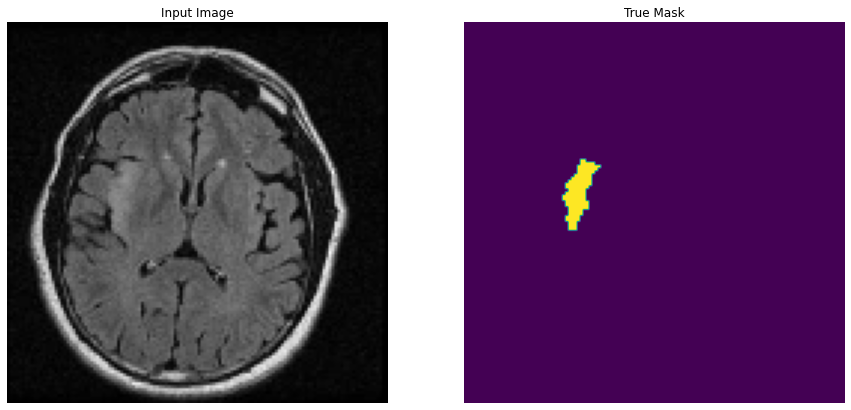

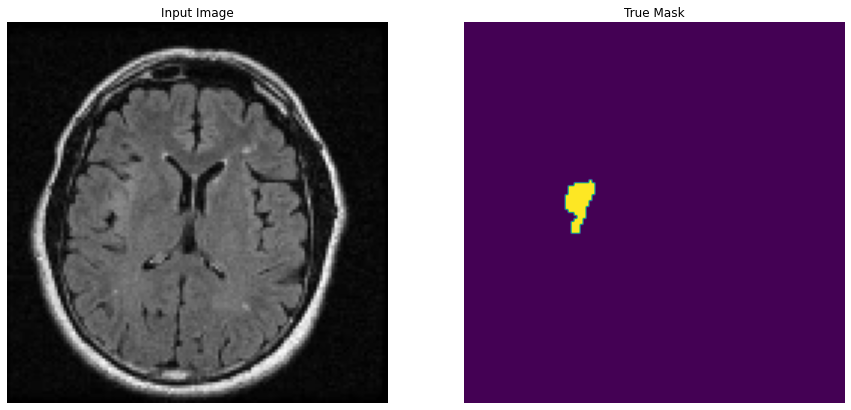

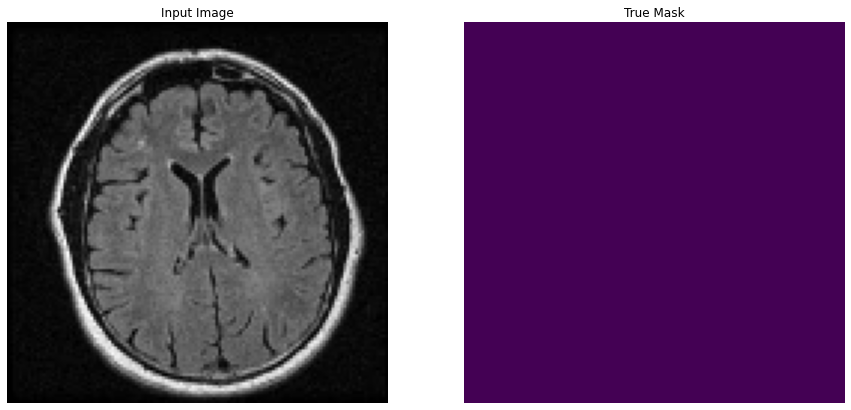

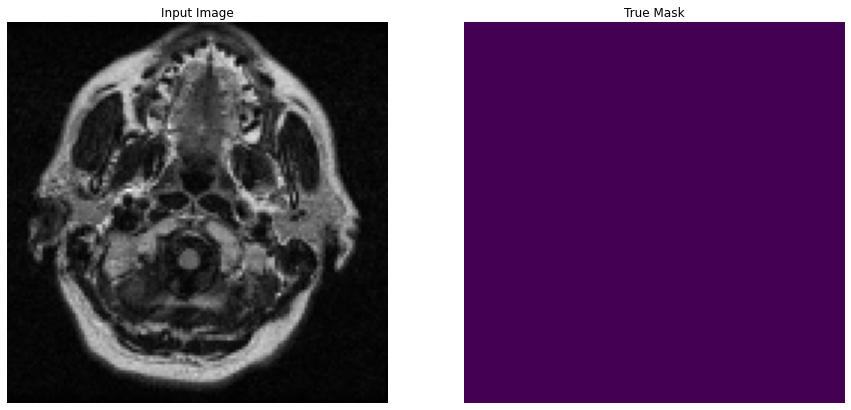

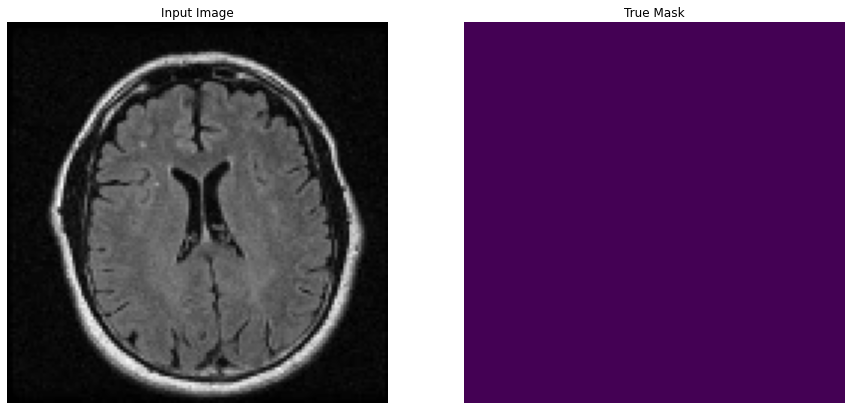

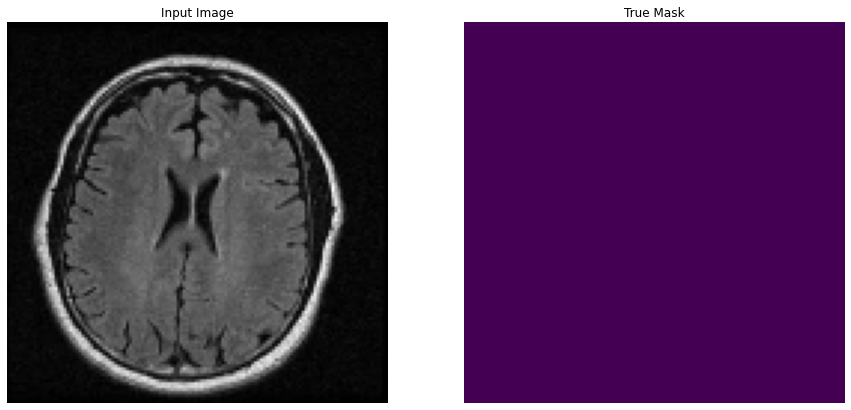

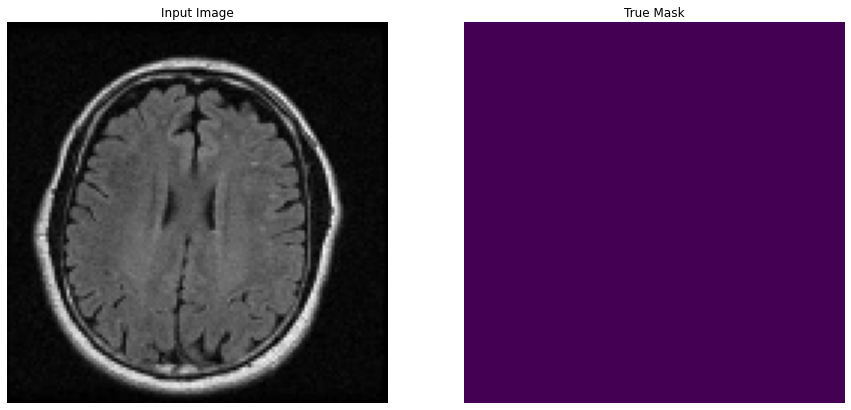

Shape input batch: (32, 128, 128, 3)
Shape sample image: (128, 128, 3)


In [29]:
# input_batch = next(iter(datasetInput))
# mask_batch = next(iter(datasetMask))
input_batch, mask_batch = next(iter(train_batches))

for i in range(23):
    sample_image = input_batch[i]
    sample_mask = mask_batch[i]
    display([sample_image, sample_mask])

print(f"Shape input batch: {input_batch.shape}")
print(f"Shape sample image: {sample_image.shape}")

## Het model: U-Net

In [30]:
base_model = tf.keras.applications.MobileNetV2(
                input_shape=[128,128,3], 
                include_top=False
            )

layer_names = [
    'block_1_expand_relu',
    'block_3_expand_relu',
    'block_6_expand_relu',
    'block_13_expand_relu',
    'block_16_project'
]
i = 3
print(f"Layer {i + 1}:\n{base_model.get_layer(layer_names[i])}\n")
print(f"Output {i + 1}:\n{base_model.get_layer(layer_names[i]).output}\n")

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create feature extraction model (convolution?)
print(f"Input:\n{base_model.input}\n")

down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

print(f"Shapes:\n")
for name in layer_names:
    print(f"{base_model.get_layer(name).output.shape}\n") 

Layer 4:

Output 4:
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 576), dtype=tf.float32, name=None), name='block_13_expand_relu/Relu6:0', description="created by layer 'block_13_expand_relu'")

Input:
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")

Shapes:

(None, 64, 64, 96)

(None, 32, 32, 144)

(None, 16, 16, 192)

(None, 8, 8, 576)

(None, 4, 4, 320)



In [31]:
up_stack = [
    pix2pix.upsample(512,3),
    pix2pix.upsample(256, 3),
    pix2pix.upsample(128, 3),
    pix2pix.upsample(64, 3)
]

In [32]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128,128,3])
    
    # Downsampling
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])
#     print(x)
#     print(type(skips))
#     for skip in skips:
#         print(skip.shape)
    
    # upsampling
    for up, skip in zip(up_stack,skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])
    
    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, 
        kernel_size=3, 
        strides=2, 
        padding='same'
    )
    
    x = last(x)
    #print(f"Transposed:\n{x.shape}")
    
    return tf.keras.Model(inputs=inputs, outputs=x)

### Compiling

In [33]:
model = unet_model(output_channels=2)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

## Geef elke pixel een kleur

In [34]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [35]:
x = tf.constant(np.arange(15).reshape(3,5))
x = x[tf.newaxis, ...]
x

<tf.Tensor: shape=(1, 3, 5), dtype=int32, numpy=
array([[[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14]]])>

## In beeld brengen

In [36]:
def show_predictions(dataset=None, num=1, model_to_use=model):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model_to_use.predict(image)
            display([
                image[0],
                mask[0],
                create_mask(pred_mask)
            ])
    else:
        display([
            sample_image,
            sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))
        ])

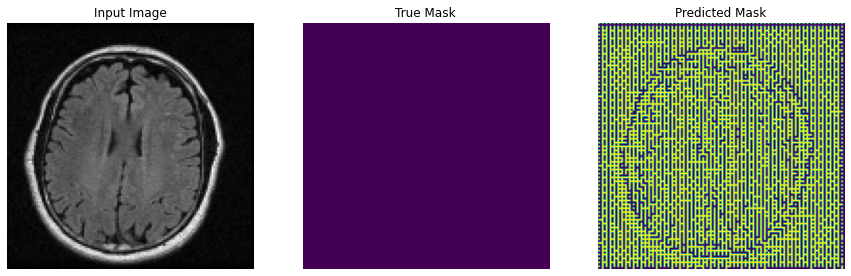

In [37]:
show_predictions()

## Het model trainen

In [38]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [39]:
EPOCHS = 3
VAL_SUBSPLITS = 5
VALIDATION_STEPS = STEPS_PER_EPOCH // VAL_SUBSPLITS

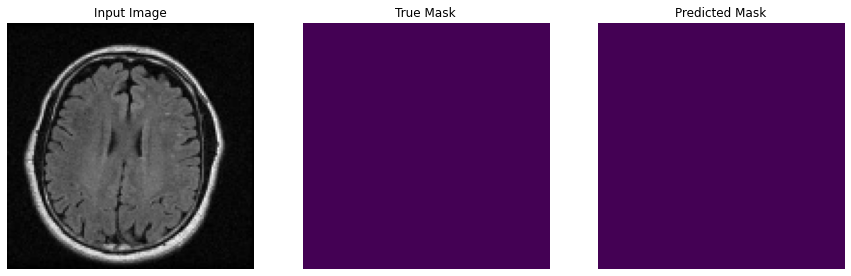


Sample Prediction after epoch 3

62/62 [==============================] - 83s 1s/step - loss: 0.0277 - accuracy: 0.9910 - val_loss: 0.0299 - val_accuracy: 0.9916


In [40]:
model_history = model.fit(
    train_batches,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_batches,
    callbacks=[DisplayCallback()]
)

In [41]:
model.predict(sample_image[tf.newaxis, ...]).shape
# test_batches

(1, 128, 128, 2)

## Visualiseer de voorspellingen

In [42]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

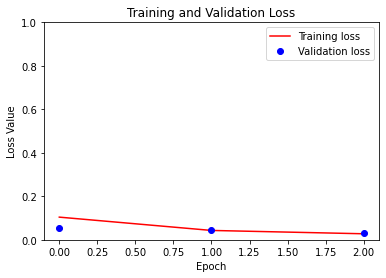

In [43]:
plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

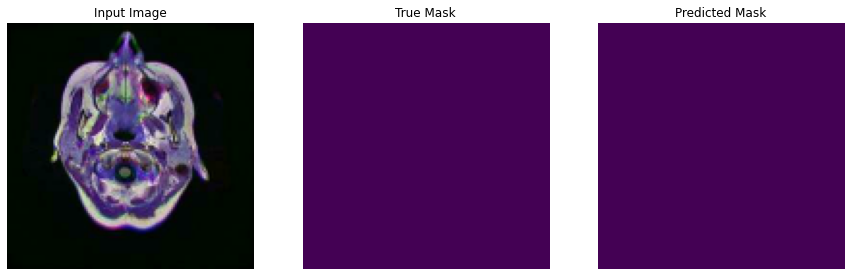

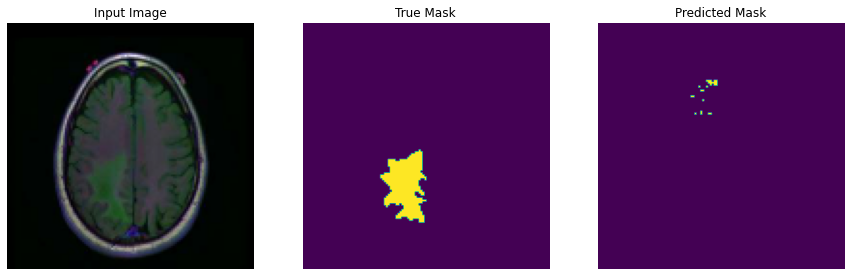

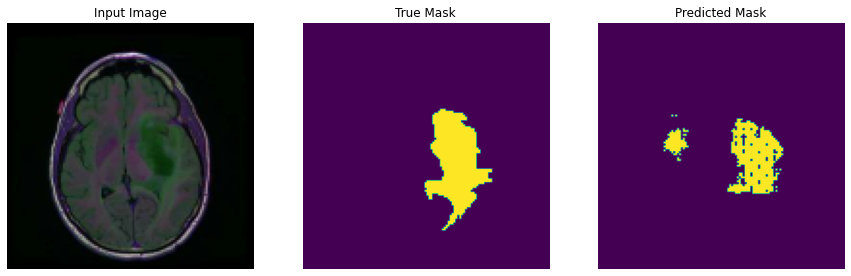

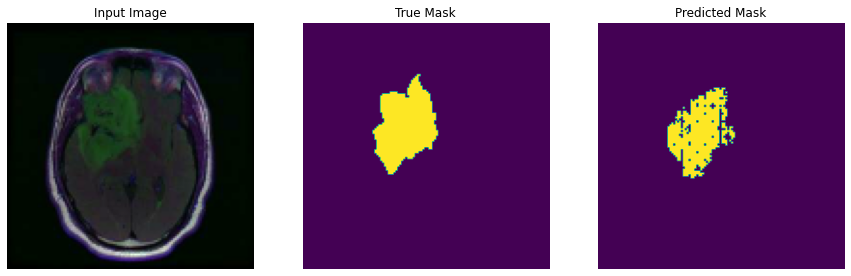

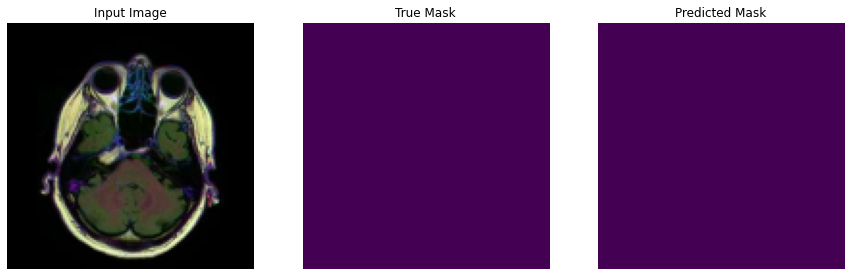

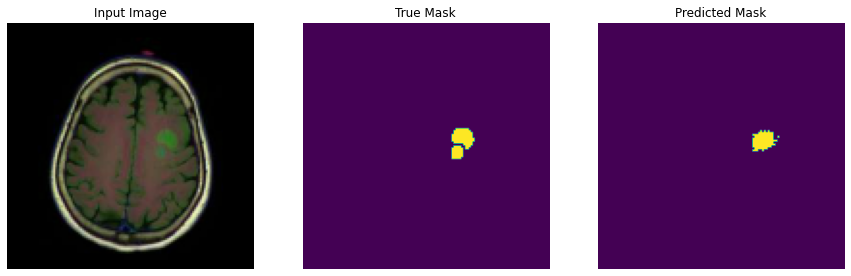

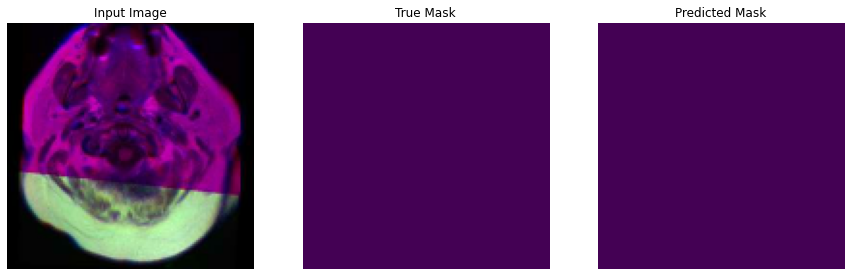

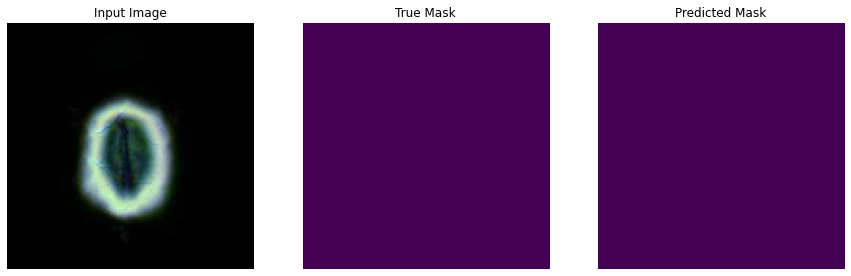

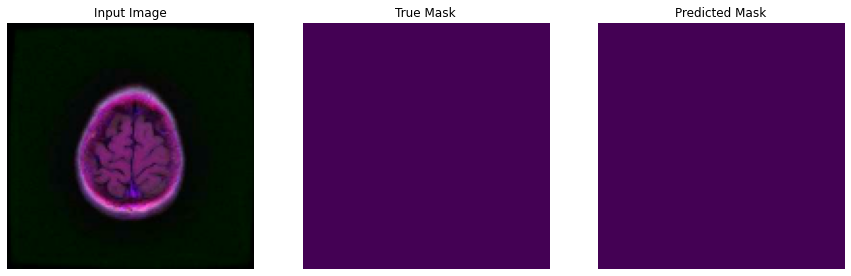

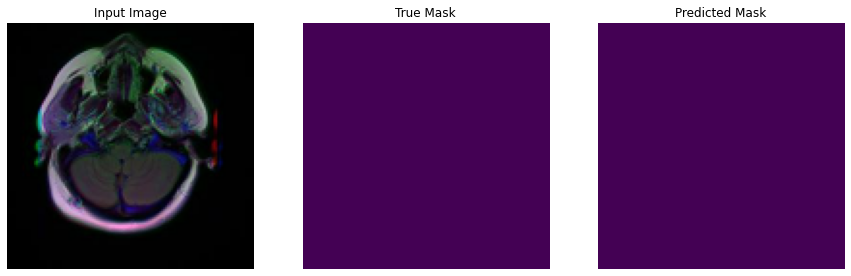

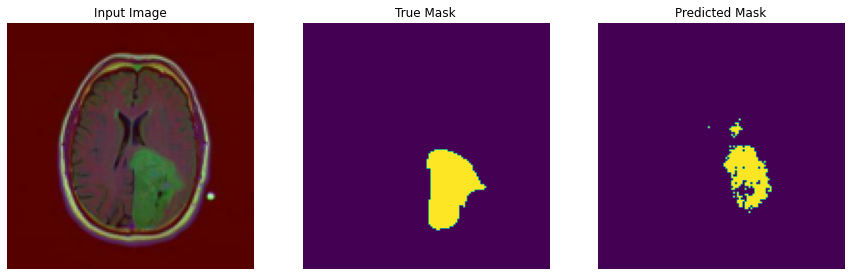

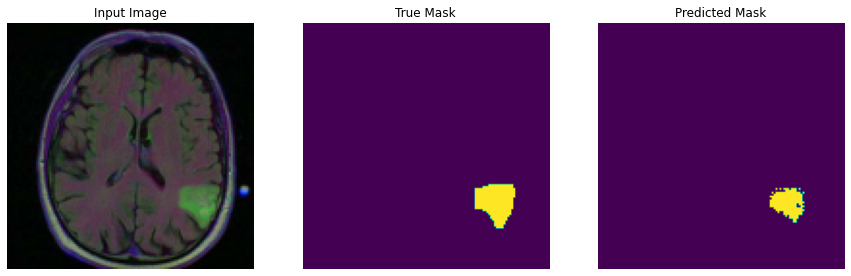

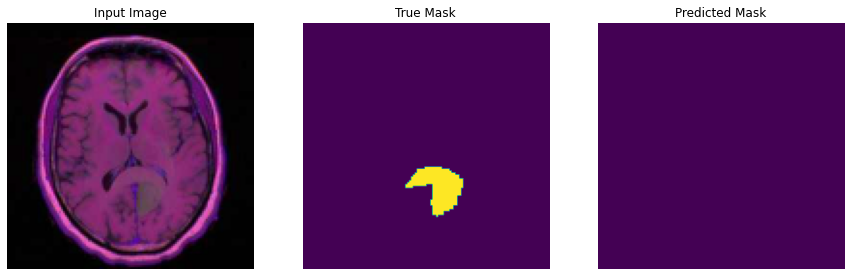

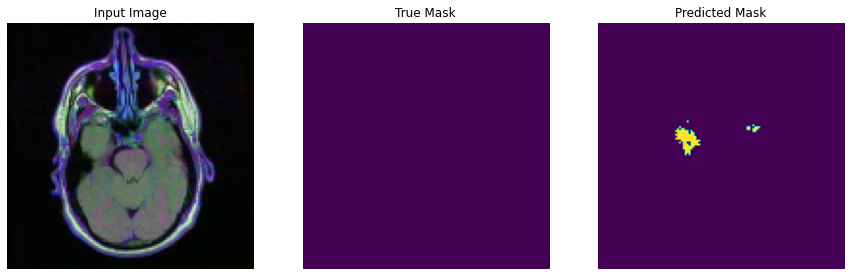

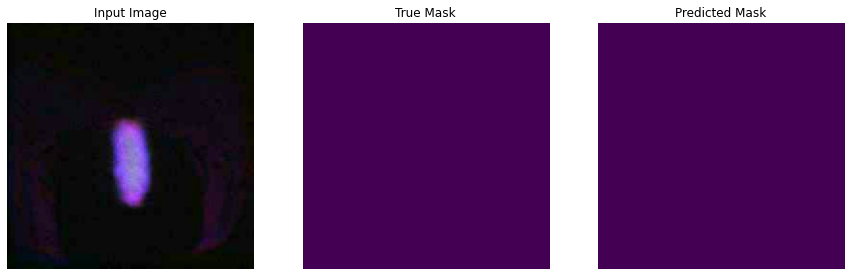

In [44]:
show_predictions(test_batches, 15)

## Gewichten toevoegen aan classes

### Elke pixel krijgt een gewicht

In [45]:
def add_sample_weights(image, label):
    # The weights for each class, with the constraint that:
    #     sum(class_weights) == 1.0
    class_weights = tf.constant([1.0, 40.0])
    class_weights = class_weights/tf.reduce_sum(class_weights)

    # Create an image of `sample_weights` by using the label at each pixel as an 
    # index into the `class weights`.
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

    return image, label, sample_weights

In [46]:
for image, label, sample_weights in train_batches.map(add_sample_weights):
    print(f"Min value: {np.min(sample_weights)};\nMax value: {np.max(sample_weights)};")
    break

Min value: 0.016393441706895828;
Max value: 0.9836065769195557;


In [47]:
weighted_model = unet_model(output_channels=2)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     loss=tf.keras.losses.SparseBinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
#     metrics=
)

In [48]:
weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=2,
    steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/2
62/62 [==============================] - 76s 1s/step - loss: 0.0071 - accuracy: 0.9320
Epoch 2/2
62/62 [==============================] - 74s 1s/step - loss: 0.0037 - accuracy: 0.9529


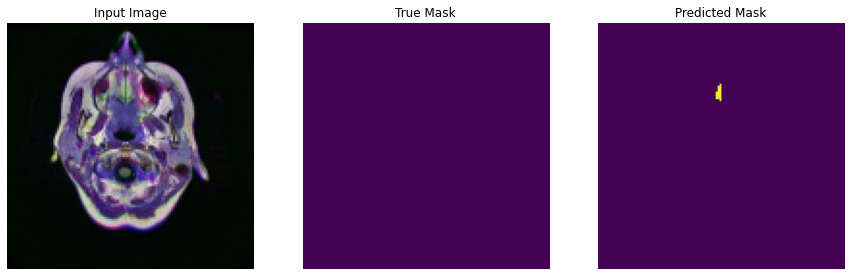

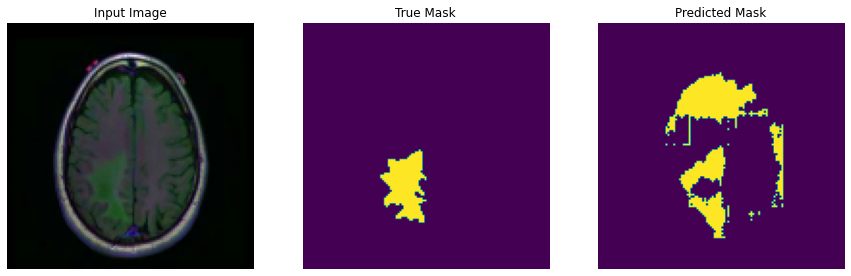

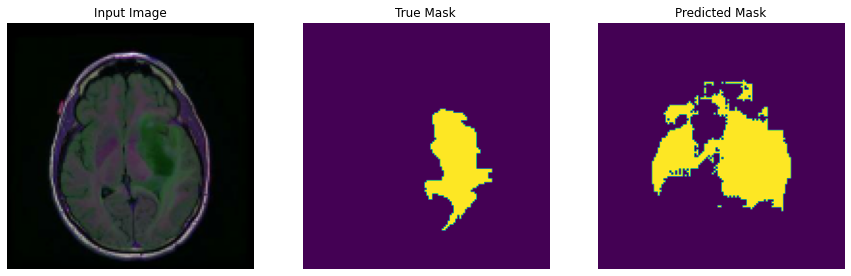

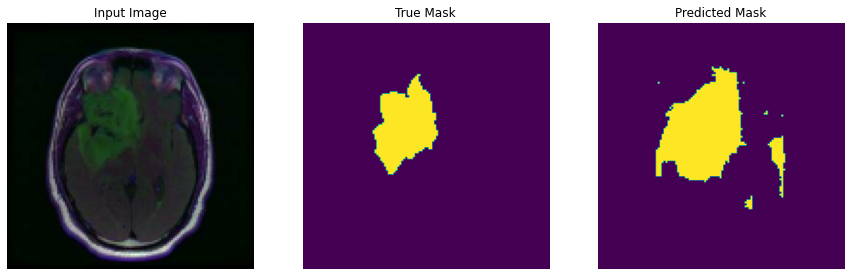

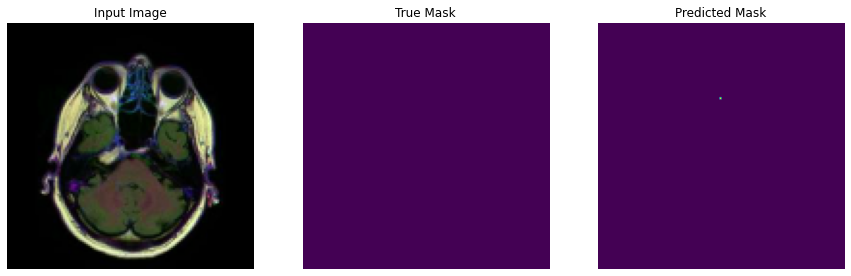

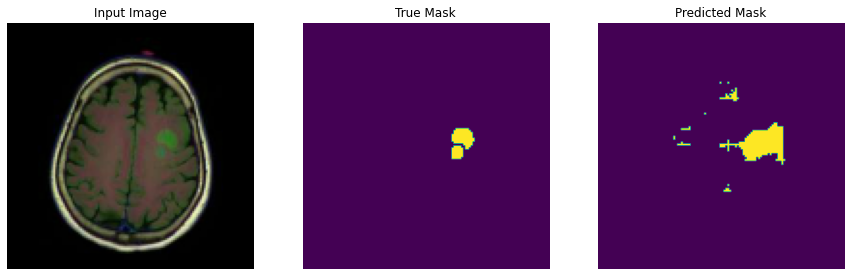

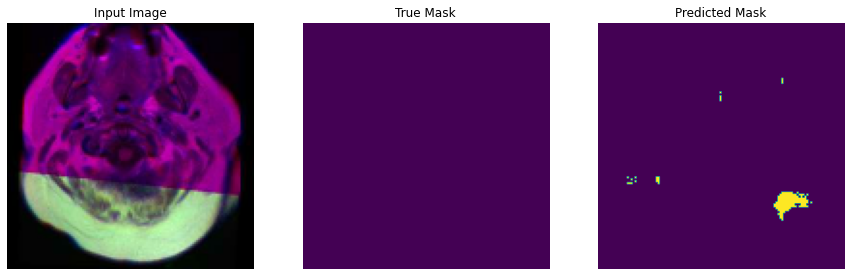

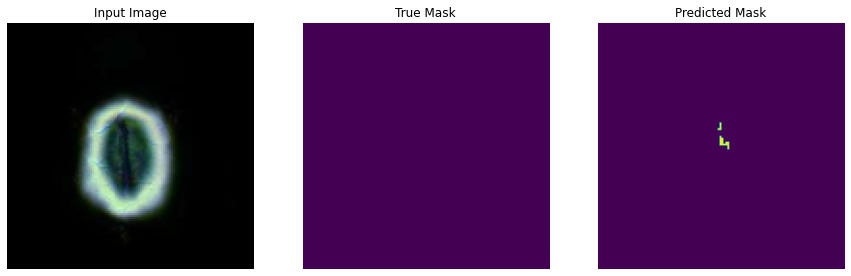

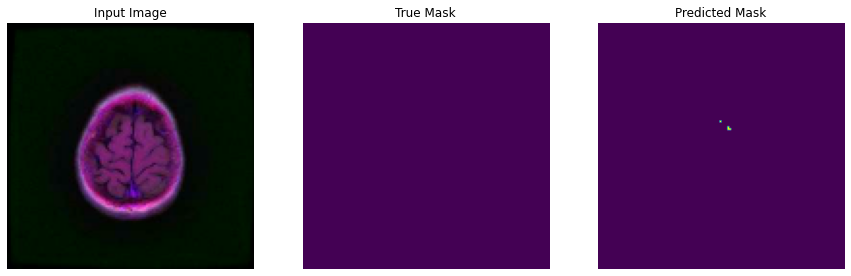

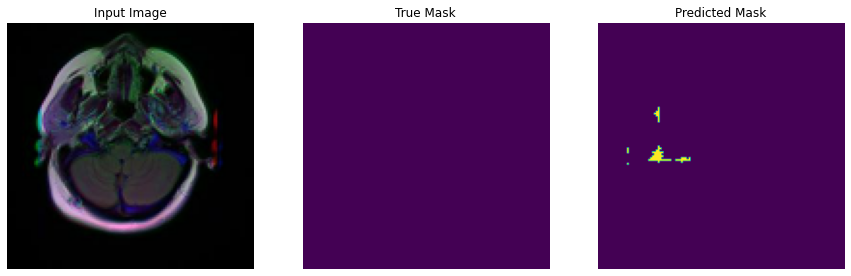

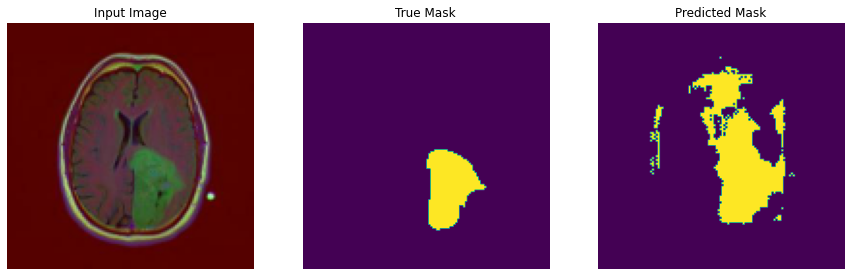

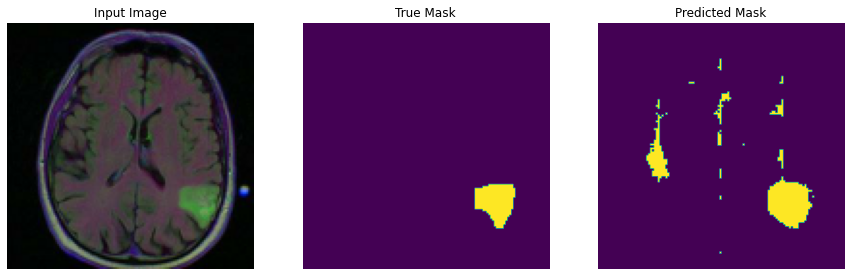

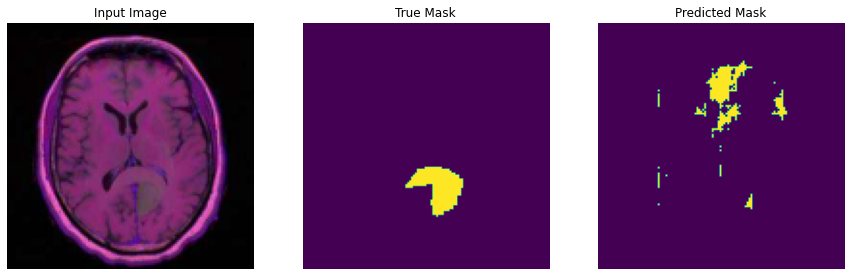

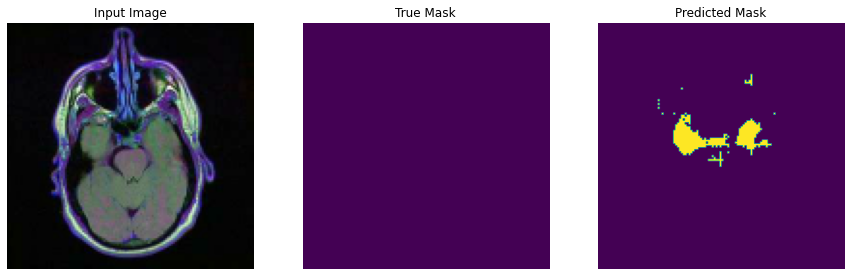

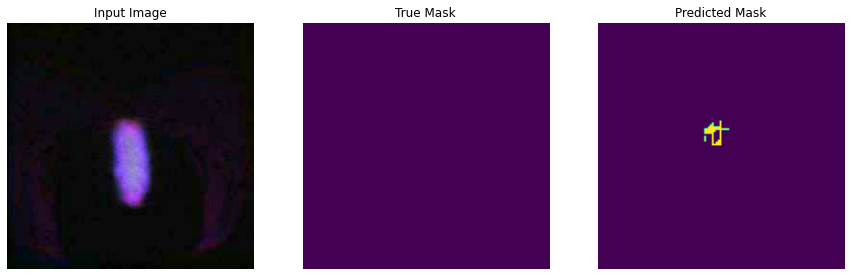

In [49]:
show_predictions(test_batches, 15, weighted_model)